In [1]:
!pip install ht CoolProp fluids xlrd xlwt

     |████████████████████████████████| 899 kB 858 kB/s 
     |████████████████████████████████| 4.2 MB 4.0 MB/s 
     |████████████████████████████████| 2.1 MB 6.6 MB/s 
     |████████████████████████████████| 96 kB 2.1 MB/s 
     |████████████████████████████████| 99 kB 3.5 MB/s 
  Created wheel for fluids: filename=fluids-1.0.3-py3-none-any.whl size=1479500 sha256=dd39c6d983827b97dbcd4ac02ff6c6be1001c97f0eb1ed9f939992f6d0f1e149
  Stored in directory: /root/.cache/pip/wheels/5f/b7/22/db1c694ed45cbbd4c2af5e4bc6b8dc34436c22028525ac2143
  Created wheel for ht: filename=ht-1.0.1-py3-none-any.whl size=837891 sha256=f7cdcf6a6a9671f5d65fafe666d02511963c0abf22972d1e0153bf35cd815204
  Stored in directory: /root/.cache/pip/wheels/27/7f/fd/663f7442317cb8408db8d87f256bb804274910c8f1c081cad1
Successfully built fluids ht


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xlwt as xw
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
lista_data = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        lista_data.append(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import ht
import CoolProp as cp
import fluids
from shutil import copyfile
copyfile(src = "../input/prop-fluidos-intercambiadores/prop_fluidos_intercambiadores.py", dst = "../working/prop_fluidos_intercambiadores.py")
from prop_fluidos_intercambiadores import fluido_intercambiador
# Carga Datos Excel
data_excel = pd.read_excel(lista_data[1],sheet_name=1)

FileNotFoundError: [Errno 2] No such file or directory: '../input/prop-fluidos-intercambiadores/prop_fluidos_intercambiadores.py'

HIPOTESIS DE CALCULO:

1. Intercambiador de calor tubular de tubos lisos (sin aletas)
2. Flujo de gases de combustión de biomasa dentro de tubos
3. Flujo cruzado de aire externo a tubos
4. Distribución de tubos alineados

In [3]:
data = data_excel.to_numpy() # datos del archivo excel
#constantes de calculo
g = 9.8; cal2joule = 4.184
###########################################################
#           DATOS  del Intercambiador  
#
###########################################################
# Definición de Flujos
Gases = fluido_intercambiador('Gases combustion') 
Aire = fluido_intercambiador('Aire')
# Temperaturas
Gases.temp_entrada = data[20,4]    
Gases.temp_salida = data[21,4]
Aire.temp_entrada = data[22,4]
Aire.temp_salida = data[12,5]
# Calor
Calor_ingreso = data[17,4]*cal2joule*1e3/3600
Calor_intercambiado = data[18,4]*cal2joule*1e3/3600
Q = Calor_intercambiado
Gases.calor_intercambiado, Aire.calor_intercambiado = [Q,Q]

# Geometría del Intercambiador
Tubo_dext = data[13,4]
Tubo_esp = data[13,6]*1e-3
Tubo_dint = Tubo_dext-Tubo_esp*2
Tubo_long = 2.68
paso_tubos = data[47,4]
Ncarcasa = 2
Rf = data[58,4]  #factor de ensuciamiento. Ver Cao pag 524

Observación: Se propone un paso de tubos p = 1.5 D. En intercambiadores casco y tubo, lo usual es encontrar pasos p= D o p = 1.3D. Ver pej 
- Shah, R. K., & Sekulic, D. P. (2003). Fundamentals of heat exchanger design. John Wiley & Sons. 
- Cao, E. (2010). Heat transfer in process engineering. McGraw-Hill Education. (pags 509-522)

Pero la elección p = 1.5D tiene razones de facilidad en la limpieza, pej.

In [4]:
#Capacidad Térmica Mínima
Cmin = np.min((Aire.cp*Aire.caudal*Aire.rho,Gases.cp*Gases.caudal*Gases.rho))
#Mayor Salto Térmico del sistema
DeltaT_max = Gases.temp_entrada-Aire.temp_entrada
#Calor Máximo disponible
Qmax = Cmin*DeltaT_max
#ficiencia térmica
eficiencia = Q/Qmax

print('Capacidad Térmica Mínima Cmin = %.1f W/K'%Cmin)
print('Calor Máximo disponible Qmax=%.1f kW'%(Qmax*1e-3))
print('Eficiencia térmica del equipo = %.2f'%eficiencia)

Capacidad Térmica Mínima Cmin = 305.1 W/K
Calor Máximo disponible Qmax=115.9 kW
Eficiencia térmica del equipo = 0.53


La estimación del factor $F_T$ para este tipo de intercambiadores la podemos estimar en base a resultado como los presentados en: 
- Annaratone, Donatello. Handbook for heat exchangers and tube banks design. Springer Science & Business Media, 2010.

Allí se definen los números adimensionales:
\begin{eqnarray}
\psi &=& \frac{ T_{CS} - T_{FE}}{ T_{CE} - T_{FE}}\\
\beta &=& \frac{ \eta \dot C_C}{ \dot C_F}\\
\gamma &=& \frac{US}{\eta C_C}
\end{eqnarray}
Y surge el factor de correción 
\begin{equation}
\chi_i = \gamma_i / \gamma
\end{equation}
siendo $\gamma_i$ el estimado para un intercambiador en general y $\gamma$ la referencia de contracorriente.

In [5]:
psi  =  (Gases.temp_salida- Aire.temp_entrada) /  (Gases.temp_entrada- Aire.temp_entrada) 
beta = eficiencia*Gases.caudal*Gases.cp / (Aire.caudal*Aire.cp)
print('psi = %.2f'%psi)
print('beta = %.2f'%beta)

#de pags 104, 105
gamma = 0.989

psi = 0.47
beta = 0.24


In [6]:
LMTD = ht.LMTD(Tci=Aire.temp_entrada, Tco=Aire.temp_salida, Thi=Gases.temp_entrada, Tho=Gases.temp_salida)

#Ft = ht.F_LMTD_Fakheri(Tci=Aire.temp_entrada, Tco=Aire.temp_salida, Thi=Gases.temp_entrada, Tho=Gases.temp_salida, shells=Ncarcasa)
################
Ft = gamma


#######################
UA = Q/(LMTD*Ft)
Upropuesto = 15
Apropuesta = UA/Upropuesto
Ntubos_0  = np.round(Apropuesta / (np.pi*Tubo_dext*Tubo_long))
Ntubos_0 = np.round(Ntubos_0/4)*4
print('Temperatura logaritmica media %.1f C'%LMTD)
print('G_Gases =%.1f m3/h'%Gases.caudal)
print('G_Aire =%.1f m3/h '%Aire.caudal)
print('Area propuesta =%.1f'%Apropuesta)
print('Numero de tubos %0d'%Ntubos_0)

Npasostubos = 1
Gases.area =  Tubo_dint**2/4*np.pi*Ntubos_0 #* Npasostubos
Gases.long = Tubo_dint
Gases.veloc = Gases.caudal / Gases.area
Gases.Reynolds()
#Npasotubos =  Re_design*(np.pi*Tubo_dext-Tubo_esp*2*Ntubos_0*m ) / (4*m_t)

Temperatura logaritmica media 247.5 C
G_Gases =0.5 m3/h
G_Aire =1.1 m3/h 
Area propuesta =16.6
Numero de tubos 32


In [7]:
###########################################################
# Determinacion de Area de pasaje del aire por la carcasa
# alrededor del paquete de tubos
###########################################################
Tubo_area_ext = Tubo_dext**2/4*np.pi
carcasa_huelgo = 20e-3
nfilas = 4
ncolumnas = Ntubos_0/nfilas

carcasa_xmax,carcasa_ymax = [paso_tubos*(ncolumnas-1)+carcasa_huelgo*2+Tubo_dext,
                                                       paso_tubos*(nfilas-1)+carcasa_huelgo*2+Tubo_dext]
carcasa_area = carcasa_xmax*carcasa_ymax

Veloc_aire_entrada  = Aire.caudal/(carcasa_xmax*Tubo_long/2)
Veloc_aire_max = Veloc_aire_entrada*paso_tubos/(paso_tubos-Tubo_dext) #esta expresión no toma en cuenta el area entre tubo y carcasa (huelgo)


Aire.area = (carcasa_xmax-Tubo_dext*ncolumnas)*Tubo_long/2
Aire.long = Tubo_dext
Aire.veloc = Aire.caudal  / Aire.area
print('Area de pasaje del Aire %.3f m2'%Aire.area)
print('Velocidad del Aire %.3f m/s'%Aire.veloc)

Area de pasaje del Aire 0.332 m2
Velocidad del Aire 3.285 m/s


In [8]:
Aire.Reynolds() 
Re = Aire.Re
pitch_parallel,pitch_normal = [paso_tubos,paso_tubos]
Pr = Aire.Pr
tube_rows = ncolumnas
Aire.Nu = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows, pitch_parallel, pitch_normal, Pr_wall=None)
Aire.hc = Aire.Nu*Aire.long / Aire.k

ŽUKAUSKAS, A. Heat transfer from tubes in crossflow. En Advances in heat transfer. Elsevier, 1972. p. 93-160.

In [9]:
Gases.Nu = ht.conv_internal.turbulent_Colburn(Gases.Re,Gases.Pr)
Gases.hc = Gases.Nu*Gases.k/Gases.long
print('Reynolds gases = %.d'%Gases.Re)
print('Coeficiente conveccion gases = %.1f'%Gases.hc)

Reynolds gases = 6921
Coeficiente conveccion gases = 19.0


COLBURN, Allan P. A method of correlating forced convection heat-transfer data and a comparison with fluid friction. International Journal of Heat and Mass Transfer, 1964, vol. 7, no 12, p. 1359-1384.

In [10]:
Twall = (Aire.hc*Aire.temp_media+Gases.hc*Gases.temp_media) / (Aire.hc+Gases.hc)
Pr_w = cp.CoolProp.PropsSI('Prandtl','T',273+Twall,'P',101.325e3,'Air')
mu_w = cp.CoolProp.PropsSI('V','T',273+Twall,'P',101.325e3,'Air')
Aire.Nu = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows, pitch_parallel, pitch_normal, Pr_wall=Pr_w)
Aire.hc = Aire.Nu*Aire.long / Aire.k

DeltaP_banco_tubos = Ncarcasa*ht.conv_tube_bank.dP_Zukauskas(Re, ncolumnas, pitch_normal, pitch_parallel, Tubo_dext, Aire.rho, Aire.veloc)
Aire.DeltaP = DeltaP_banco_tubos  #+ DeltaP_Codo
print('Banco de tubos Nu= %.2f'%Aire.Nu)
print('Banco de tubos h_c= %.2f'%Aire.hc)
print('Banco de tubos Delta P= %.2f'%Aire.DeltaP)

Banco de tubos Nu= 82.39
Banco de tubos h_c= 179.31
Banco de tubos Delta P= 43.17


In [11]:
Ulimpio = 1 / (Tubo_dext/Tubo_dint/Gases.hc+1/Aire.hc )
Rf = 0.002
U = 1 / (1/Ulimpio + Rf *(1+Tubo_dext/Tubo_dint))

A_calculo = Q / (U*LMTD*Ft)

print('U=%.2f'%U)
print('Acalculo = %.2f'%A_calculo)
print('A propuesta inicial %.2f'%Apropuesta)

U=15.15
Acalculo = 16.45
A propuesta inicial 16.62


In [12]:
# Caida de presion

# Calculo para flujo en tubos
roughness = fluids.roughness_Farshad('Carbon steel, bare', D=Tubo_dint)

f_c = fluids.friction.friction_factor(Re=Gases.Re, eD=roughness/Tubo_dint)

f_c2 = 1.2*(0.0014+0.125/Gases.Re**.32)

#Gtubos = m_c*Npasotubos*4 / (Ntubos*np.pi*Di**2)
Gtubos = Gases.caudal

Delta_p_friccion = f_c*Npasostubos*Gases.veloc**2*Tubo_long/Tubo_dint/2 *(Gases.mu/mu_w)**-0.14

#Delta_p_cabezales = 4*Npasotubos*Gtubos**2/rho_c/2

Delta_p_tubos = Delta_p_friccion#+Delta_p_cabezales
Gases.DeltaP = Delta_p_tubos
print('factor friccion tubos = %4f '%f_c)
print('Gtubos = %.1f'%Gtubos)
print('Delta p friccion = %.2f'%Delta_p_friccion)
#print('Delta p cabezales = %.2f'%Delta_p_cabezales)
print('Delta p tubos = %.2f'%Delta_p_tubos)

factor friccion tubos = 0.034917 
Gtubos = 0.5
Delta p friccion = 27.93
Delta p tubos = 27.93


In [13]:
print('Se puede volcar sobre un archivo Excel.')
# Workbook is created 
wb = xw.Workbook() 
xw.add_palette_colour("gris", 0x21)
wb.set_colour_RGB(0x21, 200, 200,200)  
# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Performance Unidad') 
style = xw.easyxf('pattern: pattern solid, fore_colour gris;')
# Input data into rows 
sheet1.write(3, 0, 'Nombre Fluido') 
sheet1.write(3, 1, 'Aire') 
sheet1.write(3, 2, 'Gases Combustión') 

sheet1.write(4, 0, 'Caudal masico (kg/s)',style) 
sheet1.write(4, 1, '%.2f'%(Aire.caudal*Aire.rho),style) 
sheet1.write(4, 2, '%.2f'%(Gases.caudal*Gases.rho),style) 

sheet1.write(5, 0, 'Temperatura Entrada') 
sheet1.write(5, 1, '%.1f'%Aire.temp_entrada) 
sheet1.write(5, 2, '%.1f'%Gases.temp_entrada) 

sheet1.write(6, 0, 'Temperatura salida',style) 
sheet1.write(6, 1, '%.1f'%Aire.temp_salida,style) 
sheet1.write(6, 2, '%.1f'%Gases.temp_salida,style) 


sheet1.write(7, 0, 'Densidad kg/m3') 
sheet1.write(7, 1, '%.2f'%Aire.rho) 
sheet1.write(7, 2, '%.2f'%Gases.rho) 

sheet1.write(8, 0, 'Viscosidad cP',style) 
sheet1.write(8, 1, '%.2f'%(1e3*Aire.mu),style) 
sheet1.write(8, 2, '%.2f'%(1e3*Gases.mu),style) 


sheet1.write(9, 0, 'Calor específico J/Kg C')
sheet1.write(9, 1, '%.1f'%Aire.cp)
sheet1.write(9, 2, '%.1f'%Gases.cp)

sheet1.write(10, 0, 'Conductividad térmica W/Kg C',style) 
sheet1.write(10, 1, '%.3f'%Aire.k,style) 
sheet1.write(10, 2, '%.3f'%Gases.k,style) 

sheet1.write(11, 0, 'Presión de entrada kPa') 
sheet1.write(11, 1, '%.1f'%(101.3))
sheet1.write(11, 2, '%.1f'%(101.3))

sheet1.write(12, 0, 'Velocidad m/s',style) 
sheet1.write(12, 1, '%.2f'%Aire.veloc,style)
sheet1.write(12, 2, '%.2f'%Aire.veloc,style)

sheet1.write(13, 0, 'Caída de presión Pa') 
sheet1.write(13, 1, '%.3f'%(Aire.DeltaP))
sheet1.write(13, 2, '%.3f'%(Gases.DeltaP))


sheet1.write(14, 0, 'Resistencia de ensuciamiento m2C/W',style) 
sheet1.write(14, 1, '%.4f'%(Rf/2),style)
sheet1.write(14, 2, '%.4f'%(Rf/2),style)

sheet1.write(15, 0, 'Calor intercambiado kW') 
sheet1.write(15, 1, '%.1f'%(Q/1e3))

sheet1.write(16, 0, 'Coeficiente Global de Transferencia',style)
sheet1.write(16, 1, '%.1f'%U,style)

sheet1.write(17, 0, 'Número de pasos por carcasa')
sheet1.write(17, 1, '%0d'%Npasostubos)

sheet1.write(18, 0, 'Número de pasos de carcasa',style)
sheet1.write(18, 1, '%.1f'%Ncarcasa,style)

sheet1.write(19, 0, 'Tubos Longitud m')
sheet1.write(19, 1, '%.2f'%Tubo_long)

sheet1.write(20, 0, 'Tubos D exterior mm',style)
sheet1.write(20, 1, '%.2f'%(Tubo_dext*1e3),style)

sheet1.write(21, 0, 'Tubos D interior mm')
sheet1.write(21, 1, '%.2f'%(Tubo_dint*1e3))
             
sheet1.write(22, 0, 'Tubos espesor mm',style)
sheet1.write(22, 1, '%.2f'%(Tubo_esp*1e3),style)
             
sheet1.write(23,0,'Carcasa Lx m')             
sheet1.write(23,1,'%.2f'%carcasa_xmax)
             
sheet1.write(24,0,'Carcasa Ly m',style)             
sheet1.write(24,1,'%.2f'%carcasa_ymax,style)

nombre_salida = 'Intercambiador_salida_TEMA.xls'
wb.save(nombre_salida)
data_salida_excel = pd.read_excel('./'+nombre_salida,skiprows=2)
data_salida_excel

Se puede volcar sobre un archivo Excel.


,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Nombre Fluido,Aire,Gases Combustión
1,Caudal masico (kg/s),1.21,0.29
2,Temperatura Entrada,20.0,400.0
3,Temperatura salida,70.0,200.0
4,Densidad kg/m3,1.11,0.62
5,Viscosidad cP,0.02,0.03
6,Calor específico J/Kg C,1007.2,1045.1
7,Conductividad térmica W/Kg C,0.028,0.044
8,Presión de entrada kPa,101.3,101.3
9,Velocidad m/s,3.29,3.29


Nusselt según paso transversal en nuestro banco de tubos.


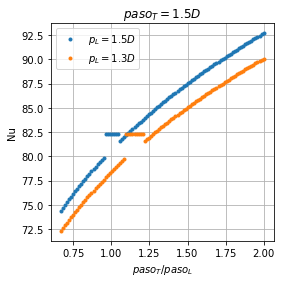

In [14]:
print('Nusselt según paso transversal en nuestro banco de tubos.')
fig0,ax0 = plt.subplots(figsize=(4,4))
paso_longitudinal = Tubo_dext*1.5
paso_transversal = np.linspace(Tubo_dext,Tubo_dext*3,100)
paso_longitudinal2 = Tubo_dext*1.3
for i,paso_ti in enumerate(paso_transversal):
    Nu = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows,paso_longitudinal,paso_ti, Pr_wall=None)
    Nu2 = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows,paso_longitudinal,paso_ti*1.3/1.5, Pr_wall=None)
    if i==0:
        lin1, = ax0.plot(paso_ti/paso_longitudinal,Nu,'.',label = '$p_L=1.5D$')
        lin2, = ax0.plot(paso_ti/paso_longitudinal,Nu2,'.',label = '$p_L=1.3D$')
    else:
        ax0.plot(paso_ti/paso_longitudinal,Nu,'.',color=lin1.get_color())
        ax0.plot(paso_ti/paso_longitudinal,Nu2,'.',color=lin2.get_color())

ax0.set_title('$paso_T = 1.5D$')
ax0.set_xlabel('$paso_T/paso_L$')
ax0.set_ylabel('Nu')
ax0.grid()
ax0.legend();

### Arreglo de tubos. Geometría

In [15]:
#datos geometría

Tubo_area_int = Tubo_dint**2/4*np.pi
Tubo_area_ext = Tubo_dext**2/4*np.pi
Ntubos = Ntubos_0

paso_tubos =pitch_normal
carcasa_huelgo = 20e-3  #Cao pag 142 10mm


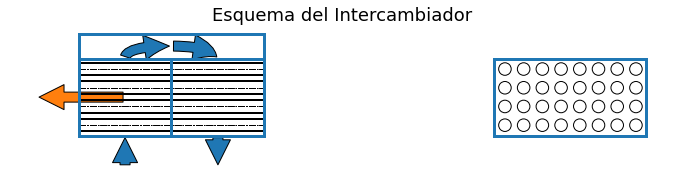

In [16]:
import matplotlib.patches as mpatches
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
escala = 1/3
coord_tubo = []
for filai in np.arange(nfilas):
    yi = filai*paso_tubos+carcasa_huelgo+Tubo_dext/2
    for columnai in np.arange(ncolumnas):
        xi = columnai*paso_tubos+carcasa_huelgo+Tubo_dext/2
        coord_tubo.append([xi,yi])

carcasa_area = carcasa_xmax*carcasa_ymax
Area_pasaje_aire = carcasa_area-Ntubos*Tubo_area_ext        
carcasa_espesor = 0
carcasa_paso = 2*Tubo_dext
fig0,ax0  = plt.subplots(figsize=(12,12))

for i,coord_tuboi in enumerate(coord_tubo):
    xi1,yi1 = coord_tuboi
    xi1 +=2; 
    ax0.add_patch(plt.Circle((xi1, yi1), Tubo_dext/2, color='k',fill=False))
    ax0.plot([0,Tubo_long*escala],[yi1,yi1],color='k',linestyle='-.',linewidth=1)
    ax0.plot([0,Tubo_long*escala],[yi1+Tubo_dext/2,yi1+Tubo_dext/2],color='k')
    ax0.plot([0,Tubo_long*escala],[yi1-Tubo_dext/2,yi1-Tubo_dext/2],color='k')
ax0.set_aspect('equal')  
lin, = ax0.plot([0,Tubo_long*escala],[0,0],linewidth=3)
color_c = lin.get_color()
ax0.plot([0,Tubo_long*escala],[carcasa_ymax,carcasa_ymax],linewidth=3,color=color_c)
ax0.plot([0,0],[0,carcasa_ymax+carcasa_paso],linewidth=3,color=color_c)
ax0.plot([Tubo_long*escala/2,Tubo_long*escala/2],[0,carcasa_ymax],linewidth=3,color=color_c)

ax0.plot([Tubo_long*escala/2,Tubo_long*escala],[carcasa_ymax,carcasa_ymax],linewidth=3,color=color_c)
ax0.plot([Tubo_long*escala/2,Tubo_long*escala],[0,0],linewidth=3,color=color_c)
ax0.plot([Tubo_long*escala,Tubo_long*escala],[0,carcasa_ymax+carcasa_paso],linewidth=3,color=color_c)

ax0.plot([0,Tubo_long*escala],[carcasa_ymax+carcasa_paso,carcasa_ymax+carcasa_paso]
         ,linewidth=3,color=color_c)

ax0.plot([2,2+carcasa_xmax],[0,0],linewidth=3,color=color_c)

ax0.plot([2,2+carcasa_xmax],[carcasa_ymax,carcasa_ymax],linewidth=3,color=color_c)
ax0.plot([2,2],[0,carcasa_ymax],linewidth=3,color=color_c)
ax0.plot([2+carcasa_xmax,2+carcasa_xmax],[0,carcasa_ymax],linewidth=3,color=color_c)

ax0.set_axis_off()
arrow0 = mpatches.FancyArrowPatch((Tubo_long*escala/4,carcasa_ymax/2), (-.2, carcasa_ymax/2),
                                 mutation_scale=50,color=colors[1],ec='k')

arrow1 = mpatches.FancyArrowPatch((Tubo_long*escala/4, -.15), (Tubo_long*escala/4, .0),
                                 mutation_scale=50,color=colors[0],ec='k')

arrow2 = mpatches.FancyArrowPatch((3*Tubo_long*escala/4, 0), (3*Tubo_long*escala/4, -.15),
                                 mutation_scale=50,color=colors[0],ec='k')
arrow3 = mpatches.FancyArrowPatch((Tubo_long*escala/4, carcasa_ymax), 
                                  (2*Tubo_long*escala/4, carcasa_ymax+carcasa_paso/2),
                                 mutation_scale=50,color=colors[0],ec='k',
                                  connectionstyle="angle3, angleA=90, angleB=0")
arrow4 = mpatches.FancyArrowPatch((2*Tubo_long*escala/4, carcasa_ymax+carcasa_paso/2),(3*Tubo_long*escala/4, carcasa_ymax), 
                                 mutation_scale=50,color=colors[0],ec='k',
                                  connectionstyle="angle3, angleA=0, angleB=120")
ax0.add_patch(arrow0)
ax0.add_patch(arrow1)
ax0.add_patch(arrow2);
ax0.add_patch(arrow3);
ax0.add_patch(arrow4);
ax0.set_title('Esquema del Intercambiador',fontsize=18);